<a href="https://colab.research.google.com/github/Shikha2889/208.1/blob/main/DataChallenge_Airlines_Copy1_(5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Imports**

In [1]:
import pandas as pd
pd.set_option("display.max_colwidth", None)

import warnings
warnings.filterwarnings('ignore')

from datetime import date
import numpy as np
import math
import time

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


**Helper Functions**

In [2]:
def read_csv(filepath: str) -> pd.DataFrame:
    """
    Reads a single CSV file present in local filesystem

    Args:
        filepath: Local path to the CSV file

    Returns: Pandas Dataframe

    """
    data = pd.read_csv(filepath, low_memory=False)
    return data

In [3]:
def merge_data_to_airport_codes(df_aiport_codes: pd.DataFrame, df_other: pd.DataFrame) -> pd.DataFrame:
    """
    Merges selected columns from Airport_Codes dataset into a desired dataset -
    first on origin airport codes, then on destination aiport codes

    Args:
        df_aiport_codes: dataframe with airport codes information
        df_other: dataframe to which the airport codes are to be merged

    Returns: Merged dataframe with origin and destination airport codes information added to the desired dataset
    """

    aiport_cols = ['TYPE', 'NAME', 'IATA_CODE', 'COORDINATES']

    df_airport_codes_ogn = df_aiport_codes[aiport_cols]
    df_airport_codes_dst = df_aiport_codes[aiport_cols]

    df_airport_codes_ogn.columns = [str(col)+'_origin' for col in df_airport_codes_ogn.columns]
    df_airport_codes_dst.columns = [str(col)+'_destination' for col in df_airport_codes_dst.columns]


    merge_origin = pd.merge(df_other, df_airport_codes_ogn,
                        how='left',
                        left_on='ORIGIN',
                        right_on='IATA_CODE_origin'
                            )

    merge_origin_dst = pd.merge(merge_origin, df_airport_codes_dst,
                            how='left',
                            left_on='DESTINATION',
                            right_on='IATA_CODE_destination'
                            )

    return merge_origin_dst

In [4]:
def get_flight_route_pair(origin: str, destination: str) -> str:
    """
    Concatenates the origin and destination string to get route pair.
    If origin='JFK' destination='ORD', then concatenated string will be 'JFK-ORD and ORD-JFK'
    If origin='ORD' destination='JFK', then concatenated string will still be 'JFK-ORD and ORD-JFK'

    Args:
        origin: origin airport code
        destination: destination airport code

    Returns: concatenated string with round-trip route
    """
    if origin < destination:
        rt_route = f'{origin}-{destination} and {destination}-{origin}'
    else:
        rt_route = f'{destination}-{origin} and {origin}-{destination}'
    return rt_route




## EDA and Quality Checks

### 1.   Airport Codes Dataset

In [114]:
airport_codes = read_csv("./Airport_Codes.csv")
print(len(airport_codes))

55369


In [115]:
airport_codes.head()

TYPE                                NAME  ELEVATION_FT CONTINENT  \
0       heliport                   Total Rf Heliport          11.0       NaN   
1  small_airport                Aero B Ranch Airport        3435.0       NaN   
2  small_airport                        Lowell Field         450.0       NaN   
3  small_airport                        Epps Airpark         820.0       NaN   
4         closed  Newport Hospital & Clinic Heliport         237.0       NaN   

  ISO_COUNTRY  MUNICIPALITY IATA_CODE                            COORDINATES  
0          US      Bensalem       NaN     -74.93360137939453, 40.07080078125  
1          US         Leoti       NaN                 -101.473911, 38.704022  
2          US  Anchor Point       NaN            -151.695999146, 59.94919968  
3          US       Harvest       NaN  -86.77030181884766, 34.86479949951172  
4          US       Newport       NaN                    -91.254898, 35.6087

--------

**Check for duplicate rows and remove them**

In [116]:
airport_codes.duplicated().sum()

np.int64(101)

In [118]:
# Remove duplicate rows

airport_codes = airport_codes.drop_duplicates()
print(f'Total rows after dropping duplicates: {len(airport_codes)}')

Total rows after dropping duplicates: 55268


---------

**Check for NULL values and Filter Data**

In [119]:
airport_codes.info()

<class 'pandas.core.frame.DataFrame'>
Index: 55268 entries, 0 to 55368
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   TYPE          55268 non-null  object 
 1   NAME          55268 non-null  object 
 2   ELEVATION_FT  48337 non-null  float64
 3   CONTINENT     27430 non-null  object 
 4   ISO_COUNTRY   55021 non-null  object 
 5   MUNICIPALITY  49564 non-null  object 
 6   IATA_CODE     9175 non-null   object 
 7   COORDINATES   55268 non-null  object 
dtypes: float64(1), object(7)
memory usage: 3.8+ MB


.

1. `ISO_COUNTRY` has `247` NULL values  
So we check how many of these NULLs are present in the data that we require for this analysis i.e. how many of those NULLs are in North America continent

In [120]:
airport_codes[airport_codes['TYPE'].isin(['medium_airport', 'large_airport'])]['ISO_COUNTRY'].isna().sum()

np.int64(12)

In [121]:
airport_codes[(airport_codes['TYPE'].isin(['medium_airport', 'large_airport'])) &
              (airport_codes['ISO_COUNTRY'].isna())]['CONTINENT'].unique()


array(['AF'], dtype=object)

All NULL values in `ISO_COUNTRY` of medium and large airports belong to the continent of Africa (AF)   
So we can ignore those NULLs for further analysis

-----------

2. Since all analysis is to be done for medium and large airports of USA, we filter the data accordingly

In [122]:
airport_codes['TYPE'].value_counts()

TYPE
small_airport     34110
heliport          11300
medium_airport     4532
closed             3675
seaplane_base      1015
large_airport       613
balloonport          23
Name: count, dtype: int64

In [123]:
# Filter data to medium and large airports of US

airport_codes_md_lg_usa = airport_codes.query("TYPE in ['medium_airport', 'large_airport'] and ISO_COUNTRY == 'US'")
len(airport_codes_md_lg_usa)

858

---------------

3. Check for NULLs in `IATA_CODE` because we will use this column to merge with flights data

In [124]:
# total null values in IATA_CODE

airport_codes_md_lg_usa['IATA_CODE'].isna().sum() #nunique()

np.int64(37)

In [125]:
airport_codes_md_lg_usa[airport_codes_md_lg_usa['IATA_CODE'].isna()].sample(10)

TYPE                                                 NAME  \
38470  medium_airport                                         Kake Airport   
49837  medium_airport         Williston Basin International Airport (U.C.)   
28376  medium_airport                 Cherry Point MCAS /Cunningham Field/   
28356  medium_airport             Camp Pendleton MCAS (Munn Field) Airport   
28413  medium_airport                          Quantico MCAF /Turner field   
49569   large_airport                                                  atl   
30460  medium_airport                        Lake Country Regional Airport   
38438  medium_airport                                    Birchwood Airport   
25963  medium_airport  South Alabama Regional At Bill Benton Field Airport   
30519  medium_airport                        Cape Canaveral AFS Skid Strip   

       ELEVATION_FT CONTINENT ISO_COUNTRY   MUNICIPALITY IATA_CODE  \
38470         172.0       NaN          US           Kake       NaN   
49837        2344.0       NaN          US      Williston       NaN   
28376          29.0       NaN          US   Cherry Point       NaN   
28356          78.0       NaN          US      Oceanside       NaN   
28413          10.0       NaN          US       Quantico       NaN   
49569           NaN       NaN          US            NaN       NaN   
30460         421.0       NaN          US    Clarksville       NaN   
38438          83.0       NaN          US      Birchwood       NaN   
25963         310.0       NaN          US  Andalusia/Opp       NaN   
30519          10.0       NaN          US    Cocoa Beach       NaN   

                             COORDINATES  
38470      -133.910003662, 56.9613990784  
49837             -103.748797, 48.258387  
28376          -76.88069916, 34.90090179  
28356          -117.3550034, 33.30130005  
28413          -77.30529785, 38.50170135  
49569                 -84.375, 33.137551  
30460  -78.56009674070002, 36.5957984924  
38438          -149.5070038, 61.41650009  
25963                -86.393799, 31.3088  
30519  -80.56659698490002, 28.4675998688

We will ignore the NULL IATA_CODES for this analysis since there are only `37` NULLs as compared to 858-37 = `821` non-null codes

-----------

In [16]:
# Remove rows with null values in IATA_CODE

airport_codes_md_lg_usa = airport_codes_md_lg_usa[~airport_codes_md_lg_usa['IATA_CODE'].isna()]
print(len(airport_codes_md_lg_usa))

821


### Visualizations

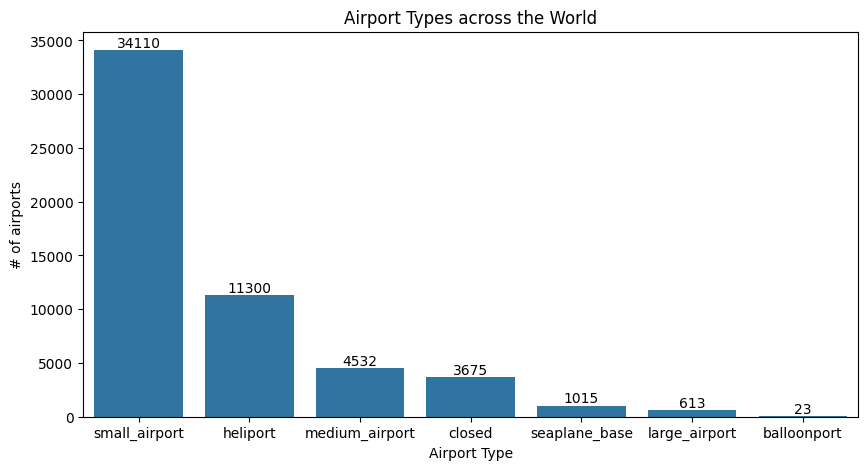

In [17]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=airport_codes, x='TYPE', order=airport_codes['TYPE'].value_counts().index)

for label in ax.containers:
    ax.bar_label(label)

ax.set_title("Airport Types across the World")
ax.set_xlabel('Airport Type')
ax.set_ylabel('# of airports')

plt.show()

These are the different types of airports across the world along with their counts

-----

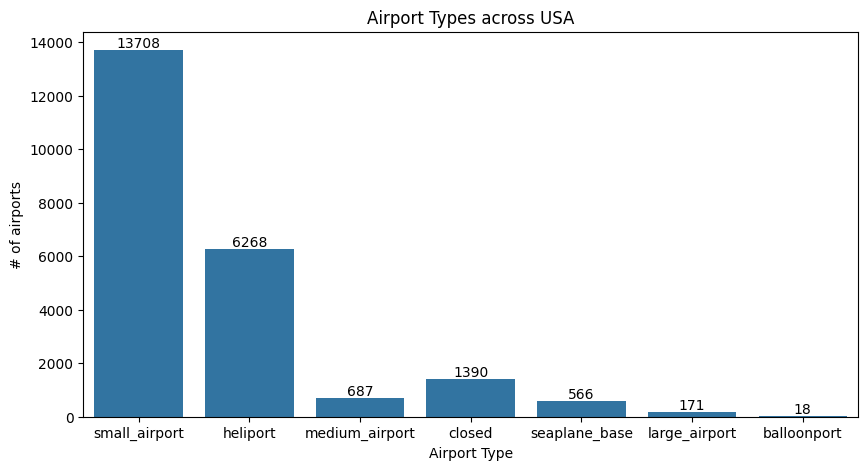

In [18]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=airport_codes[airport_codes['ISO_COUNTRY']=='US'], x='TYPE', order=airport_codes['TYPE'].value_counts().index)

for label in ax.containers:
    ax.bar_label(label)

ax.set_title("Airport Types across USA")
ax.set_xlabel('Airport Type')
ax.set_ylabel('# of airports')

plt.show()

These are the different types of airports in US along with their counts. Our analysis will be for the medium and large airports only

-----

### 2. Tickets data
this is a randomly sampled dataset from all ticket bookings in 2019 Q1

In [126]:
tickets = read_csv("Tickets.csv")
print(len(tickets))

1167285


In [127]:
tickets.columns

Index(['ITIN_ID', 'YEAR', 'QUARTER', 'ORIGIN', 'ORIGIN_COUNTRY',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'ROUNDTRIP', 'REPORTING_CARRIER',
       'PASSENGERS', 'ITIN_FARE', 'DESTINATION'],
      dtype='object')

In [128]:
tickets.head()

ITIN_ID  YEAR  QUARTER ORIGIN ORIGIN_COUNTRY ORIGIN_STATE_ABR  \
0  201912723049  2019        1    ABI             US               TX   
1  201912723085  2019        1    ABI             US               TX   
2  201912723491  2019        1    ABI             US               TX   
3  201912723428  2019        1    ABI             US               TX   
4  201912723509  2019        1    ABI             US               TX   

  ORIGIN_STATE_NM  ROUNDTRIP REPORTING_CARRIER  PASSENGERS ITIN_FARE  \
0           Texas        1.0                MQ         1.0     736.0   
1           Texas        1.0                MQ         1.0     570.0   
2           Texas        1.0                MQ         1.0     564.0   
3           Texas        1.0                MQ         1.0     345.0   
4           Texas        0.0                MQ         1.0     309.0   

  DESTINATION  
0         DAB  
1         COS  
2         MCO  
3         LGA  
4         MGM

------------

**De-duplicate tickets data**

`ITIN_ID` is a unique idetifier for each ticket booking. So we de-duplicate the data on `ITIN_ID`

In [129]:
tickets = tickets.drop_duplicates('ITIN_ID')
print(len(tickets))

1094911


1167285-1094911=`72374` duplicate records in Tickets dataset have been removed

---------

**Merging Tickets dataset with Aiport Codes**  
  
This will filter the Ticket bookings to medium and large aiports of USA

In [130]:
# left merge tickets data to airport codes (filtered on medium/large USA airports)

tickets_merged = merge_data_to_airport_codes(airport_codes_md_lg_usa, tickets)
print(len(tickets_merged))

1094911


In [131]:
tickets_merged.columns

Index(['ITIN_ID', 'YEAR', 'QUARTER', 'ORIGIN', 'ORIGIN_COUNTRY',
       'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM', 'ROUNDTRIP', 'REPORTING_CARRIER',
       'PASSENGERS', 'ITIN_FARE', 'DESTINATION', 'TYPE_origin', 'NAME_origin',
       'IATA_CODE_origin', 'COORDINATES_origin', 'TYPE_destination',
       'NAME_destination', 'IATA_CODE_destination', 'COORDINATES_destination'],
      dtype='object')

In [132]:
# keep only non-null values of IATA_CODE_origin and IATA_CODE_destination
# This will filter the flights data to only medium and large airports of USA

tickets_merged = tickets_merged[pd.notnull(tickets_merged['IATA_CODE_origin']) &
                                            pd.notnull(tickets_merged['IATA_CODE_destination'])]

print(len(tickets_merged))

1059727


In [133]:
# adding column to indicate Round Trip route for each booking

tickets_merged['ROUNDTRIP_route'] = tickets_merged.apply(lambda x: get_flight_route_pair(x['ORIGIN'], x['DESTINATION']),
                                                                        axis=1)


`ROUNDTRIP_route`: Flight Route to and fro with airport names  
This value will be same for flights going from JFK to ORD or ORD to JFK. The value will be `JFK-ORD and ORD-JFK`

---------

**Handling NULL/missing and incorrectly formatted values**

In [27]:
tickets_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1059727 entries, 0 to 1094910
Data columns (total 21 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   ITIN_ID                  1059727 non-null  int64  
 1   YEAR                     1059727 non-null  int64  
 2   QUARTER                  1059727 non-null  int64  
 3   ORIGIN                   1059727 non-null  object 
 4   ORIGIN_COUNTRY           1059727 non-null  object 
 5   ORIGIN_STATE_ABR         1059727 non-null  object 
 6   ORIGIN_STATE_NM          1059727 non-null  object 
 7   ROUNDTRIP                1059727 non-null  float64
 8   REPORTING_CARRIER        1059727 non-null  object 
 9   PASSENGERS               1058195 non-null  float64
 10  ITIN_FARE                1058959 non-null  object 
 11  DESTINATION              1059727 non-null  object 
 12  TYPE_origin              1059727 non-null  object 
 13  NAME_origin              1059727 non-null  obje

.

  
1. Convert `ITIN_FARE` from string to Numeric

In [28]:
# 1. Convert ITIN_FARE to Numeric

tickets_merged['ITIN_FARE'] = pd.to_numeric(tickets_merged['ITIN_FARE'], errors='coerce')


------

2. Check for NULL values in `ITIN_FARE` after converting to Numeric and fill NULLs

In [29]:
# ITIN_FARE null values after converting to numeric

print(tickets_merged['ITIN_FARE'].isna().sum())


3651


In [30]:
# number of unique ORIGIN airports with NULL ITIN_FARE

print(tickets_merged[tickets_merged['ITIN_FARE'].isna()]['ORIGIN'].nunique())


249


In [31]:
# fill null values with median ITIN_FARE

tickets_merged['ITIN_FARE'] = tickets_merged['ITIN_FARE'].fillna(tickets_merged['ITIN_FARE'].median())


------

3. Check for 0s in `ITIN_FARE` after converting to Numeric and replace if required

In [32]:
# total rows with ITIN_FARE=0

len(tickets_merged[tickets_merged['ITIN_FARE']==0])

11598

In [33]:
# number of unique ORIGIN airports with ZERO ITIN_FARE

tickets_merged[tickets_merged['ITIN_FARE']==0]['ORIGIN'].nunique()

280

In [34]:
# fill 0s with median ITIN_FARE

tickets_merged['ITIN_FARE'] = tickets_merged['ITIN_FARE'].replace(0, tickets_merged['ITIN_FARE'].median())


In [35]:
tickets_merged['ITIN_FARE'].describe()

count    1.059727e+06
mean     4.087977e+02
std      6.143229e+02
min      1.000000e+00
25%      2.130000e+02
50%      3.470000e+02
75%      5.240000e+02
max      3.774000e+05
Name: ITIN_FARE, dtype: float64

---------

4. Check for NULLs in `PASSENGERS`

In [36]:
# NUll values in PASSENGERS

tickets_merged['PASSENGERS'].isna().sum()

np.int64(1532)

Since we are not directly using passenger information for further analysis, we will ignore the null values in this field

--------------

**Filtering Tickets data to Round Trips only**

In [37]:
tickets_merged['ROUNDTRIP'].unique()

array([1., 0.])

In [38]:
tickets_merged['ROUNDTRIP'].value_counts()

ROUNDTRIP
1.0    640737
0.0    418990
Name: count, dtype: int64

In [39]:
tickets_merged_rt = tickets_merged[tickets_merged['ROUNDTRIP']==1]
print(len(tickets_merged_rt))

640737


---------------

### Visualizations

In [40]:
# plt.figure(figsize=(10, 5))
# ax = sns.boxplot(x=tickets_merged_rt['ITIN_FARE'])

# # for label in ax.containers:
# #     ax.bar_label(label)

# ax.set_title("Itinerary Fares across Bookings")
# ax.set_xlabel('Fare per passenger')

# plt.show()

In [41]:
fig0 = px.box(tickets_merged_rt, y='ITIN_FARE',
              title="Itinerary Fare across Round Trip Bookings",
              labels={"y":"Fare per passenger"})

fig0.layout.template = 'plotly_white'
fig0.show()

The box plot above suggests that there are many outliers in the Tickets dataset. With a median of 414 and upper and lower quartile values of 594 and 286, the plot suggests that most of the ITIN_FARE values lie between these two.

------

In [42]:
plot1 = tickets_merged_rt.groupby('ROUNDTRIP_route').size().sort_values(ascending=False)

#cap to above 200
plot1 = plot1[plot1 > 500]
fig1 = px.bar(plot1, x=plot1.index, y=plot1.values, color_discrete_sequence=['red'],
              title="Round Trip Bookings",
              labels={"ROUNDTRIP_route":"Round Trip Route", "y":"# bookings"}
             )

fig1.layout.template = 'plotly_white'
fig1.update_xaxes(tickangle=270)
fig1.show()

The above plot gives a quick insight into the Round Trip routes that have the highest number of bookings as per the Tickets dataset. Although some of these routes have higher bookings, those routes might not necessarily be the most profitable.

---------

### 3. Flights Data

In [43]:
flights = read_csv("Flights.csv")
print(len(flights))

1915886


In [44]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1915886 entries, 0 to 1915885
Data columns (total 16 columns):
 #   Column             Dtype  
---  ------             -----  
 0   FL_DATE            object 
 1   OP_CARRIER         object 
 2   TAIL_NUM           object 
 3   OP_CARRIER_FL_NUM  object 
 4   ORIGIN_AIRPORT_ID  int64  
 5   ORIGIN             object 
 6   ORIGIN_CITY_NAME   object 
 7   DEST_AIRPORT_ID    int64  
 8   DESTINATION        object 
 9   DEST_CITY_NAME     object 
 10  DEP_DELAY          float64
 11  ARR_DELAY          float64
 12  CANCELLED          float64
 13  AIR_TIME           object 
 14  DISTANCE           object 
 15  OCCUPANCY_RATE     float64
dtypes: float64(4), int64(2), object(10)
memory usage: 233.9+ MB


In [45]:
flights.isna().sum()

FL_DATE                  0
OP_CARRIER               0
TAIL_NUM             12156
OP_CARRIER_FL_NUM        0
ORIGIN_AIRPORT_ID        0
ORIGIN                   0
ORIGIN_CITY_NAME         0
DEST_AIRPORT_ID          0
DESTINATION              0
DEST_CITY_NAME           0
DEP_DELAY            50351
ARR_DELAY            55991
CANCELLED                0
AIR_TIME             56551
DISTANCE               630
OCCUPANCY_RATE         310
dtype: int64

In [46]:
flights.describe()

ORIGIN_AIRPORT_ID  DEST_AIRPORT_ID     DEP_DELAY     ARR_DELAY  \
count       1.915886e+06     1.915886e+06  1.865535e+06  1.859895e+06   
mean        1.268815e+04     1.268927e+04  1.080275e+01  5.648737e+00   
std         1.521900e+03     1.521249e+03  5.016305e+01  5.241170e+01   
min         1.013500e+04     1.013500e+04 -6.300000e+01 -9.400000e+01   
25%         1.129200e+04     1.129200e+04 -6.000000e+00 -1.500000e+01   
50%         1.288900e+04     1.288900e+04 -2.000000e+00 -6.000000e+00   
75%         1.405700e+04     1.405700e+04  7.000000e+00  8.000000e+00   
max         1.621800e+04     1.621800e+04  2.941000e+03  2.923000e+03   

          CANCELLED  OCCUPANCY_RATE  
count  1.915886e+06    1.915576e+06  
mean   2.694002e-02    6.502339e-01  
std    1.619082e-01    2.019994e-01  
min    0.000000e+00    3.000000e-01  
25%    0.000000e+00    4.800000e-01  
50%    0.000000e+00    6.500000e-01  
75%    0.000000e+00    8.247386e-01  
max    1.000000e+00    1.000000e+00

----------

**Fixing incorrect data types**  


1. Convert `FL_DATE` to datetime

In [47]:
# convert FL_DATE from string to datetime

flights['FL_DATE'] = pd.to_datetime(flights['FL_DATE'],format='mixed', errors='coerce')

In [48]:
flights['FL_DATE'].describe()

count                          1915886
mean     2019-02-15 10:15:16.912175104
min                2019-01-01 00:00:00
25%                2019-01-24 00:00:00
50%                2019-02-16 00:00:00
75%                2019-03-10 00:00:00
max                2019-03-31 00:00:00
Name: FL_DATE, dtype: object

-----

2. Convert `DISTANCE` and `AIR_TIME` from string to numeric

In [49]:
# converting string values to numeric for DISTANCE and AIR_TIME

flights['DISTANCE'] = pd.to_numeric(flights['DISTANCE'], errors='coerce')
flights['AIR_TIME'] = pd.to_numeric(flights['AIR_TIME'], errors='coerce')

In [50]:
# NULL values in DISTANCE after conversion

flights['DISTANCE'].isna().sum()

np.int64(2740)

In [51]:
# NULL values in AIR_TIME after conversion

flights['AIR_TIME'].isna().sum()

np.int64(58461)

The incorrectly formatted values in `DISTANCE` and `AIR_TIME` columns get converted to NULL.  
1. Since we are not using `AIR_TIME` for further analysis, we ignore the NULLs in this field
2. For `DISTANCE` column, the NULLs will be handled later on in EDA

------------

**Check for duplicate records and remove them**

In [52]:
flights[flights.duplicated()].shape

(4545, 16)

In [53]:
# remove duplicate records from flights data

flights = flights.drop_duplicates()
print(len(flights))

1911341


---------------

**Merging Flights data with Airport Codes data**   


This will filter flights data to medium and large airports in USA

In [54]:
# left merge the flights dataset with airport codes

flights_merged = merge_data_to_airport_codes(airport_codes_md_lg_usa, flights)
print(len(flights_merged))

1911341


In [55]:
flights_merged.columns

Index(['FL_DATE', 'OP_CARRIER', 'TAIL_NUM', 'OP_CARRIER_FL_NUM',
       'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_CITY_NAME', 'DEST_AIRPORT_ID',
       'DESTINATION', 'DEST_CITY_NAME', 'DEP_DELAY', 'ARR_DELAY', 'CANCELLED',
       'AIR_TIME', 'DISTANCE', 'OCCUPANCY_RATE', 'TYPE_origin', 'NAME_origin',
       'IATA_CODE_origin', 'COORDINATES_origin', 'TYPE_destination',
       'NAME_destination', 'IATA_CODE_destination', 'COORDINATES_destination'],
      dtype='object')

In [56]:
# keep only non-null values of IATA_CODE_origin and IATA_CODE_destination
# This will filter the flights data to only medium and large airports of USA


flights_ogn_dst_md_lg_usa = flights_merged[pd.notnull(flights_merged['IATA_CODE_origin']) &
                                            pd.notnull(flights_merged['IATA_CODE_destination'])]

print(len(flights_ogn_dst_md_lg_usa))

1878596


In [57]:
# flights_ogn_dst_md_lg_usa['IATA_CODE_origin'].isna().sum()
flights_ogn_dst_md_lg_usa['IATA_CODE_destination'].isna().sum()

np.int64(0)

----------

**Filter flights data to non-canceled flights ONLY**

In [58]:
flights_ogn_dst_md_lg_usa['CANCELLED'].unique()

array([0., 1.])

In [59]:
flights_ogn_dst_md_lg_usa['CANCELLED'].value_counts()

CANCELLED
0.0    1828047
1.0      50549
Name: count, dtype: int64

In [60]:
flights_nonC = flights_ogn_dst_md_lg_usa[flights_ogn_dst_md_lg_usa['CANCELLED']==0]
print(len(flights_nonC))

1828047


-------

**Add columns to indicate ORIGIN and DESTINATION for each flight and the Round Trip route**

In [61]:
# add a column to indicate ORIGIN-DESTINATION for each flight

flights_nonC['ORIGIN-DESTINATION'] = flights_nonC.apply(lambda x: x['ORIGIN'] + "-" + x['DESTINATION'],
                                                                   axis=1)

`ORIGIN-DESTINATION`: represents the flight route from origin to destination  
Its value will be `JFK-ORD` if flight route is JFK to ORD, and it will be `ORD-JFK` if flight route is ORD to JFK

In [62]:
flights_nonC['ROUNDTRIP_route'] = flights_nonC.apply(lambda x: get_flight_route_pair(x['ORIGIN'], x['DESTINATION']),
                                                                        axis=1)


`ROUNDTRIP_route`: Flight Route to and fro with airport names  
This value will be same for flights going from JFK to ORD or ORD to JFK. The value will be `JFK-ORD and ORD-JFK`

--------------

**Check and Handle the NULLs in `DISTANCE` field**

In [63]:
# null values in DISTANCE

flights_nonC['DISTANCE'].isna().sum()

np.int64(268)

In [64]:
# flight routes distribution for NULLs in DISTANCE

flights_nonC[flights_nonC['DISTANCE'].isna()]['ORIGIN-DESTINATION'].value_counts()

ORIGIN-DESTINATION
DFW-SFO    60
SNA-DFW    31
PIT-ORD    30
TUL-CLT    27
BOS-ORD    26
SJC-PHX    25
DFW-SAT    13
DFW-BDL    13
PHX-SJC    11
BWI-DFW     9
JFK-ORD     9
DTW-PHX     7
ATL-LAX     5
RSW-MDW     1
LAX-ORD     1
Name: count, dtype: int64

In [65]:
%%time

def fill_null_distance(x, og_dst, df):
    if not np.isnan(x):
        return x
    else:
        dist = df[df['ORIGIN-DESTINATION'] == og_dst]['DISTANCE'].min()
        return dist


flights_nonC['DISTANCE'] = flights_nonC.apply(lambda x: fill_null_distance(x['DISTANCE'],
                                                                           x['ORIGIN-DESTINATION'],
                                                                           flights_nonC),
                                              axis=1
                                             )

CPU times: user 1min 7s, sys: 804 ms, total: 1min 8s
Wall time: 1min 8s


In [66]:
flights_nonC['DISTANCE'].isna().sum()

np.int64(0)

-------

**Add additional columns to compute cost, revenue and profits**

1. Main airplane costs
    1. `cost_base` (Fuel, Oil, Maintenance, Crew): 8 dollars per mile total  
    2. `cost_misc` (Depreciation, Insurance, Other): 1.18 dollars per mile total

In [67]:
flights_nonC['cost_base'] = flights_nonC['DISTANCE']*8
flights_nonC['cost_misc'] = flights_nonC['DISTANCE']*1.18

-----

2. Destination Airport cost (based on large/medium airport type)

Assumption: Airport operational costs for the right to use the airports and related services are
fixed at 5,000 dollars for medium airports and 10,000 dollars for large airports. There is one charge for each airport where a flight lands. Thus, a round trip flight has a total of two airport charges.

In [68]:
def get_dst_airport_cost(dst_airport_type: str) -> int:
    """
    Determines destination airport cost based on type

    Args:
        dst_airport_type: destination airport type (large or medium)

    Returns: airport cost
    """

    if dst_airport_type == 'large_airport':
        return 10000
    elif dst_airport_type == 'medium_airport':
        return 5000
    else:
        return 0


In [69]:
flights_nonC['cost_dst_airport'] = flights_nonC.apply(lambda x: get_dst_airport_cost(x['TYPE_destination']),
                                                                   axis=1)


`cost_dst_airport`: cost of landing the airplane on the airport based on airport type (large/medium)

-----

3. Cost for departure and arrival delays (for delays > 15mins)

Assumption: Delays that are 15 minutes or less are free, however each additional minute of delay costs the airline $75 in added operational costs. This is charged separately for both arrival and departure delays.

In [70]:
def compute_delay_cost(arr_delay: float, dep_delay: float) -> float:
    """
    Computes airport cost for delayed arrival and delayed departure flights

    Args:
        arr_delay: arrival delay (in mins)
        dep_delay: departure delay (in mins)

    Returns: total delay cost for arrival and departure delays

    """
    if arr_delay > 15.0:
        arr_delay_cost = (arr_delay - 15.0) * 75
    else:
        arr_delay_cost = 0

    if dep_delay > 15.0:
        dep_delay_cost = (dep_delay - 15.0) * 75
    else:
        dep_delay_cost = 0

    total_delay_cost = arr_delay_cost + dep_delay_cost

    return total_delay_cost

In [71]:
flights_nonC['cost_flight_delay'] = flights_nonC.apply(lambda x: compute_delay_cost(x['ARR_DELAY'], x['DEP_DELAY']),
                                                                  axis=1)


`cost_flight_delay`: total cost incurred by each flight due to departure and arrival delays.

-------

4. Flight Occupancy based on `OCCUPANCY_RATE`



Assumption: Each plane can accommodate up to 200 passengers and each flight has an associated occupancy rate provided in the Flights data set. Do not use the Tickets data set to determine occupancy.

In [72]:
# flights_nonC['week_number'] = flights_nonC['FL_DATE'].dt.isocalendar().week
flights_nonC['total_occupancy'] = flights_nonC['OCCUPANCY_RATE']*200


`total_occupancy`: number of passengers in each flight calculated from the occupancy rate

In [73]:
# checking null values in total_occupancy

flights_nonC[flights_nonC['total_occupancy'].isna()]['ROUNDTRIP_route'].value_counts()

ROUNDTRIP_route
BOS-ORD and ORD-BOS    26
DFW-SFO and SFO-DFW     5
Name: count, dtype: int64

In [74]:
# filling null values in total_occupancy by 0

flights_nonC['total_occupancy'] = flights_nonC['total_occupancy'].fillna(0)

-------

5. Total Bag Fees collected per flight



Assumption: Baggage fee is 35 dollars for each checked bag per flight. We expect 50% of passengers to check an average of 1 bag per flight. The fee is charged separately for each leg of a round trip flight, thus 50% of passengers will be charged a total of 70 dollars in baggage fees for a round trip flight.

In [75]:
flights_nonC['total_bag_fees'] = flights_nonC.apply(lambda x: math.floor(x['total_occupancy'])*0.5*35,
                                                                axis=1)

`total_bag_fees`: total fees collected in baggage calculated as per the assumption

-------

### Visualizations

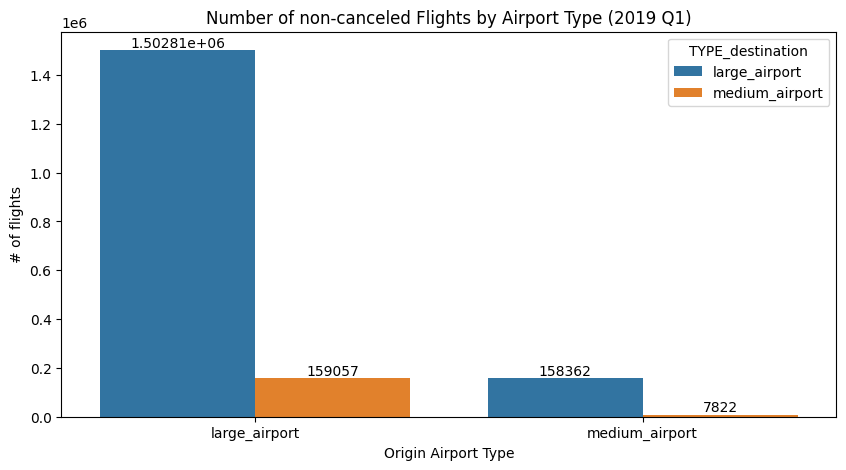

In [76]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=flights_nonC, x='TYPE_origin', hue='TYPE_destination', order=flights_nonC['TYPE_origin'].value_counts().index)

for label in ax.containers:
    ax.bar_label(label)

ax.set_title("Number of non-canceled Flights by Airport Type (2019 Q1)")
ax.set_xlabel('Origin Airport Type')
ax.set_ylabel('# of flights')

plt.show()

This count plot informs us of the most common airport combinations. From the leftmost bar we learn that the number of flights between 2 `large` airport types far exceeds other airport combinations. This insight can be utilized for choosing the most favorable airports for the new airline company.

------

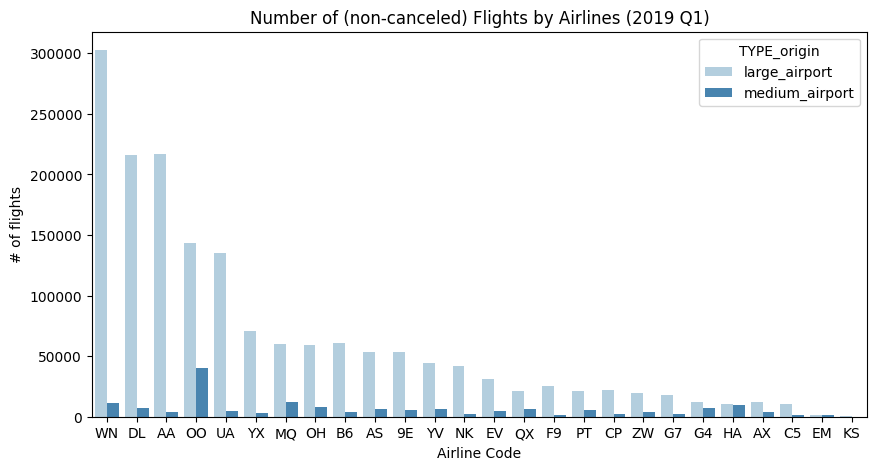

In [77]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=flights_nonC, x='OP_CARRIER', hue='TYPE_origin',
                   order=flights_nonC['OP_CARRIER'].value_counts().index,
                   palette="Blues"
                  )

ax.set_title("Number of (non-canceled) Flights by Airlines (2019 Q1)")
ax.set_xlabel('Airline Code')
ax.set_ylabel('# of flights')

plt.show()

This plot gives information about all competitor airlines and the number of flights by each in 2019 Q1. It also represents the number of flights from a large or medium airport.

------

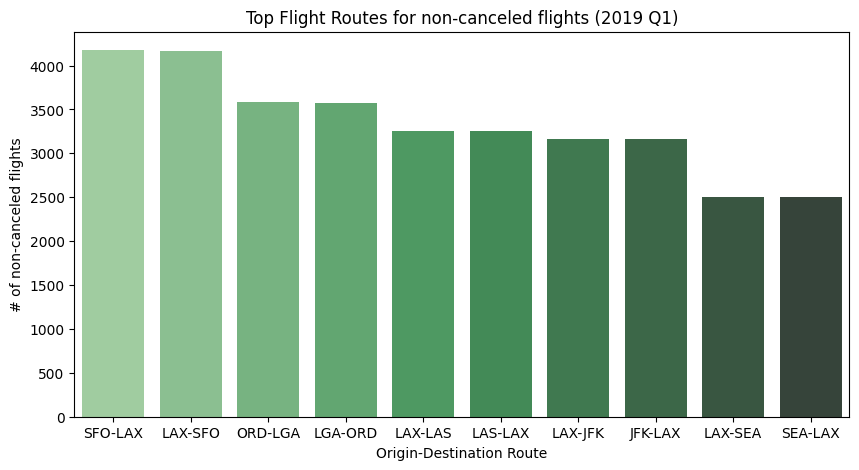

In [78]:
plt.figure(figsize=(10, 5))
ax = sns.countplot(data=flights_nonC, x='ORIGIN-DESTINATION',
                   order=flights_nonC['ORIGIN-DESTINATION'].value_counts().iloc[:10].index,
                  palette="Greens_d")

ax.set_title("Top Flight Routes for non-canceled flights (2019 Q1)")
ax.set_xlabel('Origin-Destination Route')
ax.set_ylabel('# of non-canceled flights')

plt.show()

This plot is similar to the plot in tickets dataset. It represents the origin and destination airports for highest flights. This plot gives a directional sense of the busiest airports.

-----

In [79]:
plot5 = flights_nonC.groupby('ORIGIN')['DEP_DELAY'].sum().sort_values(ascending=False)[:50]

#cap to above 200
plot5 = plot5[plot5 > 20]
fig5 = px.bar(plot5, x=plot5.index, y=plot5.values, color_discrete_sequence=['darkred'],
              title="Departure Delay from Origin Airport",
              labels={"ORIGIN":"Origin airport", "y":"Total Departure Delay (in minutes)"})

fig5.layout.template = 'plotly_white'
fig5.update_xaxes(tickangle=305)
fig5.show()

In [80]:
plot6 = flights_nonC.groupby('DESTINATION')['ARR_DELAY'].sum().sort_values(ascending=False)[:50]

#cap to above 200
plot6 = plot6[plot6 > 20]
fig6 = px.bar(plot6, x=plot6.index, y=plot6.values, color_discrete_sequence=['darkorange'],
              title="Arrival Delay at Destination Airport",
              labels={"DESTINATION":"Destination airport", "y":"Total Arrival Delay (in minutes)"})

fig6.layout.template = 'plotly_white'
fig6.update_xaxes(tickangle=305)
fig6.show()

As the new airline company has a competitive advantage of punctuality, they can use these chart to identify airports with best opportunities for fixing flight delays in departure as well as arrival. ORD, DEN, DFW have highest total departure delays while ORD, SFO, EWR have highest total arrival delays. So these airports can be taken into consideration.

----------

In [81]:
plot3 = flights_ogn_dst_md_lg_usa.groupby('ORIGIN')['CANCELLED'].sum().sort_values(ascending=False)

#cap to above 200
plot3 = plot3[plot3>200]
fig3 = px.bar(plot3, x=plot3.index, y=plot3.values, color_discrete_sequence=['darkred'],
              title = "Canceled flights by Origin airport",
              labels={"ORIGIN":"Origin airport", "y":"# canceled flights"})

fig3.layout.template = 'plotly_white'
fig3.update_xaxes(tickangle=305)
fig3.show()

The above plot shows that `ORD` airport of Chicago has the highest number of canceled flights. The new airline company can target airports based on this information to make customers that fly from this airport happy.

----------

In [82]:
plot4 = flights_ogn_dst_md_lg_usa.groupby('DESTINATION')['CANCELLED'].sum().sort_values(ascending=False)

#cap to above 200
plot4 = plot4[plot4 > 200]
fig4 = px.bar(plot4, x=plot4.index, y=plot4.values, color_discrete_sequence=['darkorange'],
              title="Cancelled flights by Destination airport",
              labels={"DESTINATION":"Destination airport", "y":"# canceled flights"})

fig4.layout.template = 'plotly_white'
fig4.update_xaxes(tickangle=305)
fig4.show()

This plot is quite similar to the previous plot giving the information about destination airports for most canceled flights.

------

## Data Munging

**What**:
We want to calculate the profit/loss for each flight.
For this, we will need the passenger fare information for each flight.  
So we will use the Tickets data to get the fare information.

**Why**:     
The passenger fare information is not given in the Flights dataset.  
So we will need to use the Tickets dataset to get the per-passenger fare information (ITIN_FARE) from each Round-Trip itinerary.  

**How**:  
We will take the mean/median of ITIN_FARE for each Round-trip route from Tickets dataset and populate every row in Flights dataset based on route information of each flight in 2019 Q1.

Since the ITIN_FARE will directly impact the profit/loss calculations, we need to check for any outliers.  

Checks:
1. we want to check if ITIN_FARE has any extreme high/low values that can affect the mean ITIN_FARE. If so, we will use median based on the data distribution
2. If there are very few (less than 3) itineraries for a route, then a high value of ITIN_FARE for those routes will affect the mean/median fare for that route.

------

**Modifying tickets data based on conditions in `ITIN_FARE`**

Check 1: Check `ITIN_FARE` for outliers

In [83]:
tickets_merged_rt['ITIN_FARE'].describe()

count    640737.000000
mean        475.141504
std         338.695854
min           1.000000
25%         286.000000
50%         414.000000
75%         594.000000
max       38400.000000
Name: ITIN_FARE, dtype: float64

Since the tickets data has many outliers in `ITIN_FARE`, we will use median instead of mean

---------

Check 2: Check for number of Round Trip bookings and corresponding itinerary fare

In [84]:
# tickets_merged_rt[tickets_merged_rt['ITIN_FARE']>5000]['ROUNDTRIP_route'].value_counts()

In [85]:
# get the Round Trip (RT) itineraries for each RT route

rt_count = tickets_merged_rt.groupby(['ROUNDTRIP_route']).size().reset_index().rename(columns={0:'ROUNDTRIP_booking_count'})


In [86]:
rt_count.head()

ROUNDTRIP_route  ROUNDTRIP_booking_count
0  ABE-ABI and ABI-ABE                        1
1  ABE-ABQ and ABQ-ABE                        2
2  ABE-AGS and AGS-ABE                        3
3  ABE-AMA and AMA-ABE                        1
4  ABE-ASE and ASE-ABE                        2

`ROUNDTRIP_booking_count`: number of round trip itineraries booked for the RT route

In [87]:
# merging the itinerary counts back to tickets data

tickets_merged_rt = pd.merge(tickets_merged_rt, rt_count, on='ROUNDTRIP_route', how='left')

In [88]:
# filtering tickets dataset based on ROUNDTRIP_booking_count and ITIN_FARE

tickets_merged_rt_flt = tickets_merged_rt[tickets_merged_rt['ROUNDTRIP_booking_count']>=3][tickets_merged_rt['ITIN_FARE']<1000]
print(len(tickets_merged_rt_flt))


596358



Since we are taking median of ITIN_FARE, we have filtered out rows where `ROUNDTRIP_booking_count` is less than 3 and also where `ITIN_FARE` is greater than 1000. This way we can exclude any outliers from profit/loss calculations
    

---------

Get the median RT fares for each RT route

In [89]:
# getting the median fare per Round Trip Route from Tickets dataset

RT_fares_med = tickets_merged_rt_flt.groupby('ROUNDTRIP_route')['ITIN_FARE'].median().reset_index().rename(columns={'ITIN_FARE': 'RT_fare'})


In [90]:
RT_fares_med.head()

ROUNDTRIP_route  RT_fare
0  ABE-AGS and AGS-ABE    299.0
1  ABE-ATL and ATL-ABE    537.0
2  ABE-AUS and AUS-ABE    391.0
3  ABE-BHM and BHM-ABE    452.0
4  ABE-BNA and BNA-ABE    349.5

`RT_fare`: Median Round Trip fare for the RT route

-----

Calculate 1-way fare from the RT fare

In [91]:
# Calculating 1-way fare from the round trip fare
# Assumption: 1-way fare is half of the round trip fare

RT_fares_med['RT_1way_fare'] = RT_fares_med['RT_fare']/2

`RT_1way_fare`: 1-way fare for the RT route

------------

**Merging fares information from previous step with Flights data to get ticket fares for each flight**

Since we have the median `RT_fare` and `RT_1way_fare` for each RT route, we use these values to populate the per-passenger fare for corresponding RT routes in Flights data

In [92]:
# Merging the median fare to the flights data
#(inner join: flights data has all flights info and tickets data has round-trip routes)

print(len(flights_nonC))

flights_nonC_RTroutes = pd.merge(flights_nonC,
                        RT_fares_med,
                        how='inner',
                        on='ROUNDTRIP_route')
print(len(flights_nonC_RTroutes))

1828047
1801330


-----

**Calculate Profits per flight**

Calculate total passenger fare using `total_occupancy` and `RT_1way_fare`  
We use `RT_1way_fare` because each row in Flights dataset is a single flight from `ORIGIN` to `DESTINATION`

In [93]:
flights_nonC_RTroutes['total_passenger_fare'] = (flights_nonC_RTroutes['total_occupancy'] *
                                                 flights_nonC_RTroutes['RT_1way_fare'])


`total_passenger_fare`: total passenger fare collected for each flight based on its occupancy and 1way fare computed from Tickets dataset

-----

Calculate total revenue, cost and profit for each flight based on all fees and costs
1. `revenue` = `total_passenger_fare` + `total_bag_fees`
2. `costs` = `cost_base` + `cost_misc` + `cost_dst_airport` + `cost_flight_delay`
3. `profit` = `revenue` - `costs`

In [94]:
# calculating total revenue and total cost for each flight

flights_nonC_RTroutes['revenue'] = flights_nonC_RTroutes['total_passenger_fare'] + \
                                        flights_nonC_RTroutes['total_bag_fees']

flights_nonC_RTroutes['costs'] = flights_nonC_RTroutes['cost_base'] + \
                                    flights_nonC_RTroutes['cost_misc'] + \
                                    flights_nonC_RTroutes['cost_dst_airport'] + \
                                    flights_nonC_RTroutes['cost_flight_delay']

flights_nonC_RTroutes['profit'] = flights_nonC_RTroutes['revenue'] - flights_nonC_RTroutes['costs']

In [95]:
flights_nonC_RTroutes.head()

FL_DATE OP_CARRIER TAIL_NUM OP_CARRIER_FL_NUM  ORIGIN_AIRPORT_ID ORIGIN  \
0 2019-03-02         WN   N955WN              4591              14635    RSW   
1 2019-03-02         WN   N8686A              3231              14635    RSW   
2 2019-03-02         WN   N201LV              3383              14635    RSW   
3 2019-03-02         WN   N413WN              5498              14635    RSW   
4 2019-03-02         WN   N7832A              6933              14635    RSW   

  ORIGIN_CITY_NAME  DEST_AIRPORT_ID DESTINATION DEST_CITY_NAME  ...  \
0   Fort Myers, FL            11042         CLE  Cleveland, OH  ...   
1   Fort Myers, FL            11066         CMH   Columbus, OH  ...   
2   Fort Myers, FL            11066         CMH   Columbus, OH  ...   
3   Fort Myers, FL            11066         CMH   Columbus, OH  ...   
4   Fort Myers, FL            11259         DAL     Dallas, TX  ...   

   cost_dst_airport  cost_flight_delay  total_occupancy  total_bag_fees  \
0             10000                0.0            194.0          3395.0   
1             10000                0.0            110.0          1925.0   
2             10000                0.0            182.0          3185.0   
3             10000                0.0            134.0          2345.0   
4             10000                0.0            124.0          2170.0   

   RT_fare  RT_1way_fare total_passenger_fare  revenue    costs   profit  
0    263.0        131.50              25511.0  28906.0  19409.5   9496.5  
1    294.0        147.00              16170.0  18095.0  18537.4   -442.4  
2    294.0        147.00              26754.0  29939.0  18537.4  11401.6  
3    294.0        147.00              19698.0  22043.0  18537.4   3505.6  
4    341.5        170.75              21173.0  23343.0  19225.9   4117.1  

[5 rows x 38 columns]

-----

**Get flight information for all flights across RT routes per day and per airplane**



Assumption: Each airplane is dedicated to one round trip route between the 2 airports
    
Assumption-2: An airplane should complete its round trip on the same day

1. Compute total flights of an airplane per day between a pair of RT route

In [96]:

fl_counts_per_day = flights_nonC_RTroutes.groupby(['FL_DATE',
                                                 'ROUNDTRIP_route',
                                                 'TAIL_NUM']).size().reset_index().rename(columns={0: 'total_fl_per_airplane'})


In [97]:
fl_counts_per_day.head()

FL_DATE      ROUNDTRIP_route TAIL_NUM  total_fl_per_airplane
0 2019-01-01  ABE-ATL and ATL-ABE   N302PQ                      1
1 2019-01-01  ABE-ATL and ATL-ABE   N311PQ                      1
2 2019-01-01  ABE-CLT and CLT-ABE   N560NN                      2
3 2019-01-01  ABE-CLT and CLT-ABE   N564NN                      1
4 2019-01-01  ABE-CLT and CLT-ABE   N565NN                      1

`total_fl_per_airplane`: total flights per day for each airplane for all RT routes

----

2. Compute total values of profit, costs, revenue and other parameters across flights of an airplane per day between the same pairs of RT routes

In [98]:
fl_params_per_day = flights_nonC_RTroutes.groupby(['FL_DATE',
                                                   'ROUNDTRIP_route',
                                                   'TAIL_NUM'])[['cost_base', 'cost_misc', 'total_occupancy',
                                                                'cost_dst_airport',
                                                                'cost_flight_delay', 'total_bag_fees',
                                                                'RT_fare', 'RT_1way_fare', 'revenue', 'costs',
                                                                'profit', 'total_passenger_fare']].sum().reset_index()

In [99]:
fl_params_per_day.head()

FL_DATE      ROUNDTRIP_route TAIL_NUM  cost_base  cost_misc  \
0 2019-01-01  ABE-ATL and ATL-ABE   N302PQ     5536.0     816.56   
1 2019-01-01  ABE-ATL and ATL-ABE   N311PQ     5536.0     816.56   
2 2019-01-01  ABE-CLT and CLT-ABE   N560NN     7696.0    1135.16   
3 2019-01-01  ABE-CLT and CLT-ABE   N564NN     3848.0     567.58   
4 2019-01-01  ABE-CLT and CLT-ABE   N565NN     3848.0     567.58   

   total_occupancy  cost_dst_airport  cost_flight_delay  total_bag_fees  \
0            112.0              5000                0.0          1960.0   
1            112.0             10000                0.0          1960.0   
2            316.0             15000                0.0          5530.0   
3            148.0             10000                0.0          2590.0   
4             70.0              5000                0.0          1225.0   

   RT_fare  RT_1way_fare  revenue     costs    profit  total_passenger_fare  
0    537.0        268.50  32032.0  11352.56  20679.44               30072.0  
1    537.0        268.50  32032.0  16352.56  15679.44               30072.0  
2    971.0        485.50  82239.0  23831.16  58407.84               76709.0  
3    485.5        242.75  38517.0  14415.58  24101.42               35927.0  
4    485.5        242.75  18217.5   9415.58   8801.92               16992.5

`'cost_base', 'cost_misc', 'total_occupancy', 'week_number', 'cost_dst_airport', 'cost_flight_delay', 'total_bag_fees', 'RT_fare', 'RT_1way_fare', 'revenue', 'costs', 'profit', 'total_passenger_fare'`  
All these values are on a per day basis for each airplane and its RT route

-----

3. Merge `fl_counts_per_day` and `fl_params_per_day` to get all info in one dataframe

In [100]:
# inner join to get all info from both dataframes

fl_info_perDay_merged = pd.merge(fl_counts_per_day,
                                 fl_params_per_day,
                                 how='inner',
                                 on=['FL_DATE', 'ROUNDTRIP_route', 'TAIL_NUM'])

In [101]:
fl_info_perDay_merged.head()

FL_DATE      ROUNDTRIP_route TAIL_NUM  total_fl_per_airplane  cost_base  \
0 2019-01-01  ABE-ATL and ATL-ABE   N302PQ                      1     5536.0   
1 2019-01-01  ABE-ATL and ATL-ABE   N311PQ                      1     5536.0   
2 2019-01-01  ABE-CLT and CLT-ABE   N560NN                      2     7696.0   
3 2019-01-01  ABE-CLT and CLT-ABE   N564NN                      1     3848.0   
4 2019-01-01  ABE-CLT and CLT-ABE   N565NN                      1     3848.0   

   cost_misc  total_occupancy  cost_dst_airport  cost_flight_delay  \
0     816.56            112.0              5000                0.0   
1     816.56            112.0             10000                0.0   
2    1135.16            316.0             15000                0.0   
3     567.58            148.0             10000                0.0   
4     567.58             70.0              5000                0.0   

   total_bag_fees  RT_fare  RT_1way_fare  revenue     costs    profit  \
0          1960.0    537.0        268.50  32032.0  11352.56  20679.44   
1          1960.0    537.0        268.50  32032.0  16352.56  15679.44   
2          5530.0    971.0        485.50  82239.0  23831.16  58407.84   
3          2590.0    485.5        242.75  38517.0  14415.58  24101.42   
4          1225.0    485.5        242.75  18217.5   9415.58   8801.92   

   total_passenger_fare  
0               30072.0  
1               30072.0  
2               76709.0  
3               35927.0  
4               16992.5

-----

**Calculate all parameters for corresponding Round Trips from aggregate flights information**

1. Calculate total Round Trips for each airplane per day

if `total_fl_per_airplane`=2, then we consider there was 1 Round Trip for the airplane  
if `total_fl_per_airplane`=3, then we consider there was 1 Round Trip and 1 1-way trip for the airplane (The 1-way trip will be excluded for further calculations)


In [102]:
# divide `total_fl_per_airplane` by 2 to get count of RTs

fl_info_perDay_merged['count_RTs'] = np.floor(fl_info_perDay_merged['total_fl_per_airplane']/2)


`count_RTs`: number of Round Trips per day by each airline for each RT route

-----

2. Calculate Round Trip aggregations for all other parameters

In [103]:
def calculate_RT_info_per_day(profit_all_flights: float, total_flights: float, num_RTs: float) -> float:
    """
    Calculates total profit for all Round Trips per airplane
    Args:
        profit_all_flights: profit for all flights by an airplane in a day
        total_flights: number of flights by an airplane in a day
        num_RTs: number of Round Trips between 2 airports by an airplane in a day

    Returns: Total RT profit for the airplane in a day
    """
    profit_per_flight = profit_all_flights/total_flights
    profit_RTs = profit_per_flight*num_RTs*2
    return profit_RTs

In [104]:
fl_info_perDay_merged['cost_delay_RTs'] = fl_info_perDay_merged.apply(lambda x:
                                                                  calculate_RT_info_per_day(
                                                                      x['cost_flight_delay'],
                                                                      x['total_fl_per_airplane'],
                                                                      x['count_RTs']
                                                                      ),
                                                                  axis=1
                                                                 )

fl_info_perDay_merged['costs_RTs'] = fl_info_perDay_merged.apply(lambda x:
                                                                  calculate_RT_info_per_day(
                                                                      x['costs'],
                                                                      x['total_fl_per_airplane'],
                                                                      x['count_RTs']
                                                                      ),
                                                                  axis=1
                                                                 )

fl_info_perDay_merged['revenue_RTs'] = fl_info_perDay_merged.apply(lambda x:
                                                                  calculate_RT_info_per_day(
                                                                      x['revenue'],
                                                                      x['total_fl_per_airplane'],
                                                                      x['count_RTs']
                                                                      ),
                                                                  axis=1
                                                                 )

fl_info_perDay_merged['profit_RTs'] = fl_info_perDay_merged.apply(lambda x:
                                                                  calculate_RT_info_per_day(
                                                                      x['profit'],
                                                                      x['total_fl_per_airplane'],
                                                                      x['count_RTs']
                                                                      ),
                                                                  axis=1
                                                                 )

All the above columns represent the parameter values for Round Trips in 1 day

## Final Recommendations

**10 Busiest Round Trip Routes**

In [105]:
fl_info_perDay_merged.groupby('ROUNDTRIP_route')['count_RTs'].sum().nlargest(10).reset_index()

ROUNDTRIP_route  count_RTs
0  LAX-SFO and SFO-LAX     2807.0
1  LGA-ORD and ORD-LGA     2564.0
2  HNL-OGG and OGG-HNL     2107.0
3  BOS-LGA and LGA-BOS     1835.0
4  JFK-LAX and LAX-JFK     1813.0
5  LAS-LAX and LAX-LAS     1469.0
6  HNL-LIH and LIH-HNL     1431.0
7  DCA-LGA and LGA-DCA     1310.0
8  HNL-KOA and KOA-HNL     1309.0
9  BOS-DCA and DCA-BOS     1294.0

--------

**10 Most Profitable Round Trip Routes**

In [106]:

RTroute_profit_summary = fl_info_perDay_merged.groupby('ROUNDTRIP_route')[['profit_RTs',
                                                                     'revenue_RTs',
                                                                     'costs_RTs',
                                                                     'count_RTs']].sum().reset_index().sort_values(['profit_RTs'],
                                                                                              ascending=False
                                                                                             )[:5]
RTroute_profit_summary

ROUNDTRIP_route    profit_RTs   revenue_RTs     costs_RTs  count_RTs
1087  DCA-LGA and LGA-DCA  4.528664e+07  8.204135e+07  3.675471e+07     1310.0
1730  HNL-OGG and OGG-HNL  4.429275e+07  8.032452e+07  3.603177e+07     2107.0
834   CLT-ILM and ILM-CLT  3.814283e+07  4.914442e+07  1.100159e+07      553.0
730   CHS-CLT and CLT-CHS  3.710486e+07  5.238270e+07  1.527784e+07      611.0
879   CLT-RIC and RIC-CLT  3.625958e+07  5.175408e+07  1.549450e+07      591.0

---------

**5 Recommended Round Trip Routes**

In [107]:
# 5 Recommended RT routes

RTroutes_recommended = fl_info_perDay_merged.groupby('ROUNDTRIP_route')[['cost_delay_RTs',
                                                                        'count_RTs',
                                                                        'profit_RTs',
                                                                        'revenue_RTs',
                                                                        'costs_RTs']].sum().reset_index().sort_values(['cost_delay_RTs',
                                                                                               'count_RTs'],
                                                                                              ascending=False
                                                                                             )[:5]

RTroutes_recommended

ROUNDTRIP_route  cost_delay_RTs  count_RTs    profit_RTs  \
2150  LGA-ORD and ORD-LGA    1.645035e+07     2564.0  1.190781e+07   
2109  LAX-SFO and SFO-LAX    1.468087e+07     2807.0  2.199965e+07   
537   BOS-LGA and LGA-BOS    1.031779e+07     1835.0  3.457232e+07   
2707  SEA-SFO and SFO-SEA    7.534450e+06     1081.0  8.134097e+06   
2684  SAN-SFO and SFO-SAN    5.621908e+06     1161.0  9.145106e+06   

       revenue_RTs     costs_RTs  
2150  1.141442e+08  1.022364e+08  
2109  1.101883e+08  8.818868e+07  
537   8.778918e+07  5.321686e+07  
2707  5.076477e+07  4.263067e+07  
2684  4.751525e+07  3.837014e+07

Since the airline company claims that it has a competitive advantage in maintaining punctuality, the 5 recommended Round Trip routes would be the ones which have highest delay costs associated with its flights along with having the highest number of Round Trips.
If other airlines are baring costs due to delays in their Round Trips, then the new airline company can use that to its advantage.

----------

**Breakeven for upfront airplane cost (90M dollars) for the 5 recommended routes**

In [108]:
def calculate_breakeven_flights_count(fl_info_perDay_merged: pd.DataFrame, RT_route: float,
                                      count_RTs: float, revenue_RTs: float) -> float:
    """
    Calculates the number of RT flights for a route given current RT flights and revenue

    Args:
        fl_info_perDay_merged: flights information dataset used to calculate unique airplanes
        RT_route: RT route name
        count_RTs: number of Round Trips for the RT_route
        revenue_RTs: revenue collected for the RT_route

    Returns: Number of RT flights that will be required to breakeven the upfront airline cost
    """

    # get total number of airplanes flying between the RT route
    total_airplanes = fl_info_perDay_merged[fl_info_perDay_merged['ROUNDTRIP_route']==RT_route]['TAIL_NUM'].nunique()

    # each airplane costs 90M dollars
    total_airplane_cost = total_airplanes * 90000000

    breakeven_RTs = (total_airplane_cost * count_RTs)/revenue_RTs
    breakeven_RT_flights = breakeven_RTs * 2

    return breakeven_RT_flights

In [109]:
RTroutes_recommended['breakeven_RT_flights'] =  RTroutes_recommended.apply(lambda x:
                                                                             calculate_breakeven_flights_count(
                                                                                fl_info_perDay_merged,
                                                                                 x['ROUNDTRIP_route'],
                                                                                 x['count_RTs'],
                                                                                 x['revenue_RTs']
                                                                             ), axis=1
                                                                            )

In [110]:
RTroutes_recommended

ROUNDTRIP_route  cost_delay_RTs  count_RTs    profit_RTs  \
2150  LGA-ORD and ORD-LGA    1.645035e+07     2564.0  1.190781e+07   
2109  LAX-SFO and SFO-LAX    1.468087e+07     2807.0  2.199965e+07   
537   BOS-LGA and LGA-BOS    1.031779e+07     1835.0  3.457232e+07   
2707  SEA-SFO and SFO-SEA    7.534450e+06     1081.0  8.134097e+06   
2684  SAN-SFO and SFO-SAN    5.621908e+06     1161.0  9.145106e+06   

       revenue_RTs     costs_RTs  breakeven_RT_flights  
2150  1.141442e+08  1.022364e+08          3.242733e+06  
2109  1.101883e+08  8.818868e+07          4.938500e+06  
537   8.778918e+07  5.321686e+07          1.320610e+06  
2707  5.076477e+07  4.263067e+07          2.982053e+06  
2684  4.751525e+07  3.837014e+07          3.193069e+06

`breakeven_RT_flights`: the number of round trip flights needed to break even the upfront airline cost

The breakeven flights correspond to the number of flights by an airplane if it only flies this one RT route

----

## Key Performance Indicators to Track

1. Delays and the cost associated with those delays is one of the key performance indicators that should be tracked
2. The airports that are large and have maximum flight cancellations should also be considered for future opportunities
3. The occupancy rate is also a major factor that contributes to revenue, so round trip routes that have higher occupancy rates should be tracked

### What's Next ...

1. In the Airport Codes dataset, we eliminated/removed the rows which had NULL values in IATA_CODE. But the codes can be filled based on Municipality column using this website - https://www.nationsonline.org/oneworld/IATA_Codes/airport_code_list.htm

2. The `total_occupancy` column that we add in flights dataset has NULLs which have been filled with `0`s. However, these can be filled based on mean occupancy of other flights for the same routes

3. All Round Trip routes are generated based on a per day basis. The same can be done on a per week basis, which could generate more Round Trips since an airplane may complete its round trip on a different day